In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

train_data = datasets.FashionMNIST('./', download=True, train=True, transform=transform)
test_data = datasets.FashionMNIST('./', download=True, train=False, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [3]:
CHANNELS = 1
LR = 0.00001
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_EPOCH = 300

In [4]:
class Mask(nn.Conv2d):
  def __init__(self, mask_type, *args, **kwargs):
    super(Mask, self).__init__(*args, **kwargs)
    self.register_buffer('mask', self.weight.data.clone())
    _, _, h, w = self.weight.size()
    self.mask.fill_(1)
    if mask_type == 'A':
      self.mask[:, :, h//2, w//2:] = 0
      self.mask[:, :, h//2+1:, :] = 0
    if mask_type == 'B':
      self.mask[:, :, h//2, w//2+1:] = 0
      self.mask[:, :, h//2+1:, :] = 0

  def forward(self, x):
    self.weight.data *= self.mask
    return super(Mask, self).forward(x)

In [5]:
class PixelCNN(nn.Module):
  def __init__(self):
    super(PixelCNN, self).__init__()
    self.conv1 = Mask('A', 1, 64, kernel_size=7, stride=1, padding=3, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.activ1 = nn.LeakyReLU(0.2)

    self.layers = nn.ModuleList()
    for i in range(1, 9):
        self.layers.append(
            nn.Sequential(
                Mask('B', 64, 64, 7, 1, 7//2, bias=False),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.2)
            )
        )

    self.out = nn.Conv2d(64, 256, 1)

  def forward(self, x):
    x = self.activ1(self.bn1(self.conv1(x)))
    for layer in self.layers:
          x = layer(x)
    x = self.out(x)
    return x

In [6]:
import torch.optim as optim

pixelCNN = PixelCNN().to(DEVICE)
opt = optim.Adam(pixelCNN.parameters(), lr=LR, betas=(0.5, 0.999))

if torch.cuda.device_count() > 1:
  pixelCNN = nn.DataParallel(pixelCNN)
loss_PCNN = nn.CrossEntropyLoss()

In [7]:
import os
from torch.autograd import Variable


loss_overall = []

for i in range(NUM_EPOCH):

  pixelCNN.train(True)
  loss_epoch = 0

  for images, labels in train_loader:

    target = (images[:, 0, :, :] * 255).long()
    images = images.to(DEVICE)
    target = target.to(DEVICE)

    opt.zero_grad()

    output = pixelCNN(images)
    loss = loss_PCNN(output, target)
    loss.backward()
    opt.step()
    loss_epoch+=loss

  if(i % 10 == 0):
    print(f'Epoch: {i}. Loss: {loss_epoch.item()}')
  loss_overall.append(loss_epoch)

Epoch: 0. Loss: 4237.3037109375
Epoch: 10. Loss: 2335.294921875
Epoch: 20. Loss: 2140.662841796875
Epoch: 30. Loss: 2073.195556640625
Epoch: 40. Loss: 2039.60888671875
Epoch: 50. Loss: 2016.580078125
Epoch: 60. Loss: 1999.8426513671875
Epoch: 70. Loss: 1986.614013671875
Epoch: 80. Loss: 1975.2978515625
Epoch: 90. Loss: 1964.240966796875
Epoch: 100. Loss: 1956.552490234375
Epoch: 110. Loss: 1948.236572265625
Epoch: 120. Loss: 1941.9202880859375
Epoch: 130. Loss: 1935.026123046875
Epoch: 140. Loss: 1928.468017578125
Epoch: 150. Loss: 1924.480712890625
Epoch: 160. Loss: 1917.8779296875
Epoch: 170. Loss: 1913.2562255859375
Epoch: 180. Loss: 1909.291015625
Epoch: 190. Loss: 1904.115234375
Epoch: 200. Loss: 1899.7308349609375
Epoch: 210. Loss: 1896.873291015625
Epoch: 220. Loss: 1893.5748291015625
Epoch: 230. Loss: 1891.1898193359375
Epoch: 240. Loss: 1888.2828369140625
Epoch: 250. Loss: 1885.8602294921875
Epoch: 260. Loss: 1881.242431640625
Epoch: 270. Loss: 1880.399658203125
Epoch: 280. Lo

(-0.5, 451.5, 31.5, -0.5)

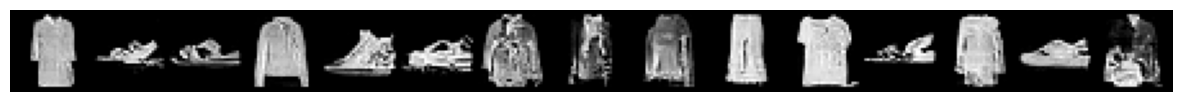

In [10]:
import torchvision
import matplotlib.pyplot as plt

if torch.cuda.device_count() > 1:
    pixelCNN = nn.DataParallel(pixelCNN)
pixelCNN.eval()

sample = torch.Tensor(15, 1, 28, 28).to(DEVICE)
sample.fill_(0)

for i in range(28):
  for j in range(28):
    out = pixelCNN(sample)
    probs = F.softmax(out[:,:,i,j], dim=-1).data
    sample[:,:,i,j] = torch.multinomial(probs, 1).float() / 255.0

plt.figure(figsize=(15, 10))
grid = torchvision.utils.make_grid(sample, nrow=20, padding=2)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')

###Висновок:

Модель адекватно натренувалась, помітно що  loss спадає належним чином.По результатах помітно що вона навчилась генерувати схожі до реалістичних зображень
проте чим більше епох, тим кращі результати отримуються.
Крім того, для покраення поточної моделі варто додати residual blocks, оскільки це допоможе

В ході тестів я зрозуміла, що на точність моделі найбільше повпливали параметри оптимізатора, learning rate, а також складність моделі (кількість шарів).

Дана модель є зручною у використанні, оскільки має ряд наступних переваг:
1. За рахунок того що вона враховує залежності між пікселями модель здатна генерувати чіткі зображення високої якості.
2. Легка у реалізації, оскільки по факту це просто згорткові шари з накладаннями певних масок. (В ефективніших моделях ще додаються residual блоки).
3. Модель видає стабільні результати.

Проте є деякі недоліки:
1. Модель гарно відслідковує локальні залежності, проте має певні обмеження у врахуванні глобального контексу зображення.
2. Повільна генерація зображень, оскільки це відбувається піксель за пікселем => висока обчислювальна вартість.
